# Perf Tools Analisys

Neste notebook iremos verificar as analises referentes ao perf tools da implementação do loop fusion, verificando quanto de acesso ao cache misses e cache references é utilizado.

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = "11.5"

In [53]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [54]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [55]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [56]:
import re
MILLION = 1000000000
def parse_perf_file(fname, methodology='MB'):
    spname = fname.split('/')[-1].split('-')
    
    cores = 4
    if methodology == 'Sequential':
        cores = 1

    lineDict = {
        'dataset': spname[1],
        'algorithm': spname[2],
        'ensemble': spname[3],
        'methodology': methodology,
        'cores': cores,
        'batch_size': spname[5],
        'rate': spname[6],
        'cache_misses': None,
        'cache_references': None
    }

    with open (fname) as file:
        cache_misses = "0"
        cache_references = "0"
        for line in file:
            line = re.findall(r'\S+', line)
            try:
                if line[1]:
                    if line[1] == "cache-misses:u":
                        cache_misses = line[0]
                        
                    if line[1] == "cache-references:u":
                        cache_references = line[0]
            except IndexError:
                pass
    
    lineDict['cache_misses'] = float(cache_misses.replace(',', '')) / MILLION
    lineDict['cache_references'] = float(cache_references.replace(',', '')) / MILLION
            
    return lineDict

In [57]:
#Folder inside results directory that contains all the MOA dump files for these experiments
%cd /Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/
folderMOADumps = "/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/results/analise-perf/without-loop-fusion/15092022"
wantedCSVfilename = "without-loop-fusion-perf"

/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy


In [58]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

response_mb = []
with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("perf-"):
            response_mb.append(
                parse_perf_file(f'{os.fsdecode(directory)}/{filename}', 'MB')
            )

df_mini_batching = pd.DataFrame.from_dict(response_mb)
display(df_mini_batching.sort_values(by=['dataset', 'algorithm']).drop_duplicates())

,dataset,algorithm,ensemble,methodology,cores,batch_size,rate,cache_misses,cache_references
16,GMSC,AdaptiveRandomForestExecutorMAXChunk,25,MB,4,50,1,2.08,75.64
5,GMSC,LBagExecutorMAXChunk,25,MB,4,50,1,1.52,54.79
1,GMSC,OzaBagASHTExecutorMAXChunk,25,MB,4,50,1,0.62,18.83
10,GMSC,OzaBagAdwinExecutorMAXChunk,25,MB,4,50,1,0.58,23.08
19,GMSC,OzaBagExecutorMAXChunk,25,MB,4,50,1,0.64,18.14
15,GMSC,StreamingRandomPatchesExecutorMAXChunk,25,MB,4,50,1,3.96,149.18
18,airlines,AdaptiveRandomForestExecutorMAXChunk,25,MB,4,50,1,44.68,"2,016.44"
2,airlines,LBagExecutorMAXChunk,25,MB,4,50,1,65.83,"2,566.72"
17,airlines,OzaBagASHTExecutorMAXChunk,25,MB,4,50,1,3.82,271.89
9,airlines,OzaBagAdwinExecutorMAXChunk,25,MB,4,50,1,18.65,819.64


In [59]:
#Folder inside results directory that contains all the MOA dump files for these experiments
%cd /Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/
folderMOADumps = "/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/results/analise-perf/loop-fusion/15092022"
wantedCSVfilename = "loop-fusion-perf"

/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy


In [60]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

response = []
with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("perf-"):
            response.append(
                parse_perf_file(f'{os.fsdecode(directory)}/{filename}', 'MB-LF')
            )

df_loopfusion = pd.DataFrame.from_dict(response)
display(df_loopfusion.sort_values(by=['dataset', 'algorithm']).drop_duplicates())

,dataset,algorithm,ensemble,methodology,cores,batch_size,rate,cache_misses,cache_references
16,GMSC,AdaptiveRandomForestExecutorMAXChunk,25,MB-LF,4,50,1,1.90,73.53
5,GMSC,LBagExecutorMAXChunk,25,MB-LF,4,50,1,1.35,56.97
1,GMSC,OzaBagASHTExecutorMAXChunk,25,MB-LF,4,50,1,0.38,12.59
10,GMSC,OzaBagAdwinExecutorMAXChunk,25,MB-LF,4,50,1,0.55,23.93
19,GMSC,OzaBagExecutorMAXChunk,25,MB-LF,4,50,1,0.38,12.14
15,GMSC,StreamingRandomPatchesExecutorMAXChunk,25,MB-LF,4,50,1,3.62,137.77
18,airlines,AdaptiveRandomForestExecutorMAXChunk,25,MB-LF,4,50,1,44.69,"1,995.38"
2,airlines,LBagExecutorMAXChunk,25,MB-LF,4,50,1,63.03,"2,546.02"
17,airlines,OzaBagASHTExecutorMAXChunk,25,MB-LF,4,50,1,1.77,141.22
9,airlines,OzaBagAdwinExecutorMAXChunk,25,MB-LF,4,50,1,17.91,819.79


In [61]:
#Folder inside results directory that contains all the MOA dump files for these experiments
%cd /Users/reginaldo.junior/Documents/Ufscar/comparison-xue3m-minibatching/
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/analise-perf/loop-fusion-sequential/15092022"
wantedCSVfilename = "sequential-perf"

/Users/reginaldo.junior/Documents/Ufscar/comparison-xue3m-minibatching


In [62]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

response = []
with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("perf-"):
            response.append(
                parse_perf_file(f'{os.fsdecode(directory)}/{filename}', 'Sequential')
            )

df_sequential = pd.DataFrame.from_dict(response)
display(df_sequential.sort_values(by=['dataset', 'algorithm']).drop_duplicates())

,dataset,algorithm,ensemble,methodology,cores,batch_size,rate,cache_misses,cache_references
20,GMSC,AdaptiveRandomForestSequential,25,Sequential,1,1,1,2.17,75.42
6,GMSC,LeveragingBag,25,Sequential,1,1,1,1.64,51.17
7,GMSC,OzaBag,25,Sequential,1,1,1,0.71,16.96
13,GMSC,OzaBagASHT,25,Sequential,1,1,1,0.70,17.74
18,GMSC,OzaBagAdwin,25,Sequential,1,1,1,0.82,21.51
14,GMSC,StreamingRandomPatches,25,Sequential,1,1,1,4.39,159.60
10,airlines,AdaptiveRandomForestSequential,25,Sequential,1,1,1,45.01,"2,003.20"
17,airlines,LeveragingBag,25,Sequential,1,1,1,59.57,"2,355.70"
0,airlines,OzaBag,25,Sequential,1,1,1,3.36,159.96
2,airlines,OzaBagASHT,25,Sequential,1,1,1,3.80,270.28


In [63]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [64]:
dataframe_general = pd.concat([df_sequential, df_mini_batching, df_loopfusion], ignore_index=True)
df = select_columns_and_rename_values(dataframe_general)
df.iloc[:,5:] = df.iloc[:,5:].astype('float64')

print(df[["dataset", "algorithm", "methodology", "cache_references", "cache_misses"]].sort_values(by=['dataset', 'algorithm', 'methodology']).to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
dataset & algorithm & methodology & cache_references & cache_misses \\
\midrule
GMSC & ARF & MB & 75.642132 & 2.075966 \\
GMSC & ARF & MB-LF & 73.531468 & 1.902505 \\
GMSC & ARFSequential & Sequential & 75.418060 & 2.167053 \\
GMSC & LBag & MB & 54.793937 & 1.522229 \\
GMSC & LBag & MB-LF & 56.966556 & 1.352171 \\
GMSC & LBagSequential & Sequential & 51.172665 & 1.640410 \\
GMSC & OB & MB & 18.139237 & 0.635437 \\
GMSC & OB & MB-LF & 12.144867 & 0.380199 \\
GMSC & OB & Sequential & 16.963878 & 0.714284 \\
GMSC & OBASHT & MB & 18.834790 & 0.617312 \\
GMSC & OBASHT & MB-LF & 12.590176 & 0.380752 \\
GMSC & OBASHT & Sequential & 17.737306 & 0.698709 \\
GMSC & OBAdwin & MB & 23.075276 & 0.576190 \\
GMSC & OBAdwin & MB-LF & 23.928447 & 0.545891 \\
GMSC & OBAdwin & Sequential & 21.513399 & 0.818424 \\
GMSC & SRP & MB & 149.179733 & 3.960516 \\
GMSC & SRP & MB-LF & 137.774344 & 3.622523 \\
GMSC & SRP & Sequential & 159.603147 & 4.389362 \\
airlines & ARF & MB & 

## Dataframe perf tools

In [65]:

display(df.sort_values(by=['dataset', 'algorithm']))

,dataset,algorithm,ensemble,methodology,cores,batch_size,rate,cache_misses,cache_references
40,GMSC,ARF,25,MB,4,50.00,1.00,2.08,75.64
64,GMSC,ARF,25,MB-LF,4,50.00,1.00,1.90,73.53
20,GMSC,ARFSequential,25,Sequential,1,1.00,1.00,2.17,75.42
29,GMSC,LBag,25,MB,4,50.00,1.00,1.52,54.79
53,GMSC,LBag,25,MB-LF,4,50.00,1.00,1.35,56.97
6,GMSC,LBagSequential,25,Sequential,1,1.00,1.00,1.64,51.17
7,GMSC,OB,25,Sequential,1,1.00,1.00,0.71,16.96
43,GMSC,OB,25,MB,4,50.00,1.00,0.64,18.14
67,GMSC,OB,25,MB-LF,4,50.00,1.00,0.38,12.14
13,GMSC,OBASHT,25,Sequential,1,1.00,1.00,0.70,17.74


In [66]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg, markers, alg_order, ax2):
    lwidth = 0.50

    c1 = 'tab:red'
    c2 = 'tab:blue'

    labels = df.methodology
    x = np.arange(len(labels))

    ax.plot(x, pd.to_numeric(df.cache_misses), linestyle='--', marker='o', color=c1, linewidth=lwidth, label='cache-misses')
    ax.tick_params(axis='y', labelcolor=c1)

    ax2.plot(x, pd.to_numeric(df.cache_references), linestyle='-.', marker='x', color=c2, linewidth=lwidth, label='cache-references')
    ax2.tick_params(axis='y', labelcolor=c2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)


In [67]:
def linear_graph(markers=True, tables=False, cache_misses = True):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    
    fig, axs = plt.subplots(4, 6, figsize=(16, 8), tight_layout=True, gridspec_kw={'hspace': 0.4, 'wspace': 0.9, 'bottom': 0.1})
    filename = "perftools-analysis-mblf"
    #for each algorithm
    for ds in datasets:
        title = ''
        my_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:
            my_id = algorithms.index(alg)
                
            ax = axs[int(my_ds)][my_id]
            ax.set_title(f'{alg}')

            ax2 = ax.twinx()  

            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)

            if tables:
                display(df_aux)

            #plot (include) the series in the chart
            gen_lines(df_aux, ax, alg, markers, my_id, ax2)

            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(ds)
                        
            if (my_id%6 == 0 and my_ds%4 == 0):
                ax.legend(loc='lower center', bbox_to_anchor=(4.2, -4.8))
                ax2.legend(loc='lower center', bbox_to_anchor=(5.8, -4.8))

    #retrieves the handles and labels to create a global legend
    # handles, labels = axs[0][0].get_legend_handles_labels()
    # lgd = fig.legend(handles, ['cache-misses'], loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png', dpi=300)
    plt.savefig(f'figures/{filename}.eps', bbox_inches='tight')

/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_15713/3590543159.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


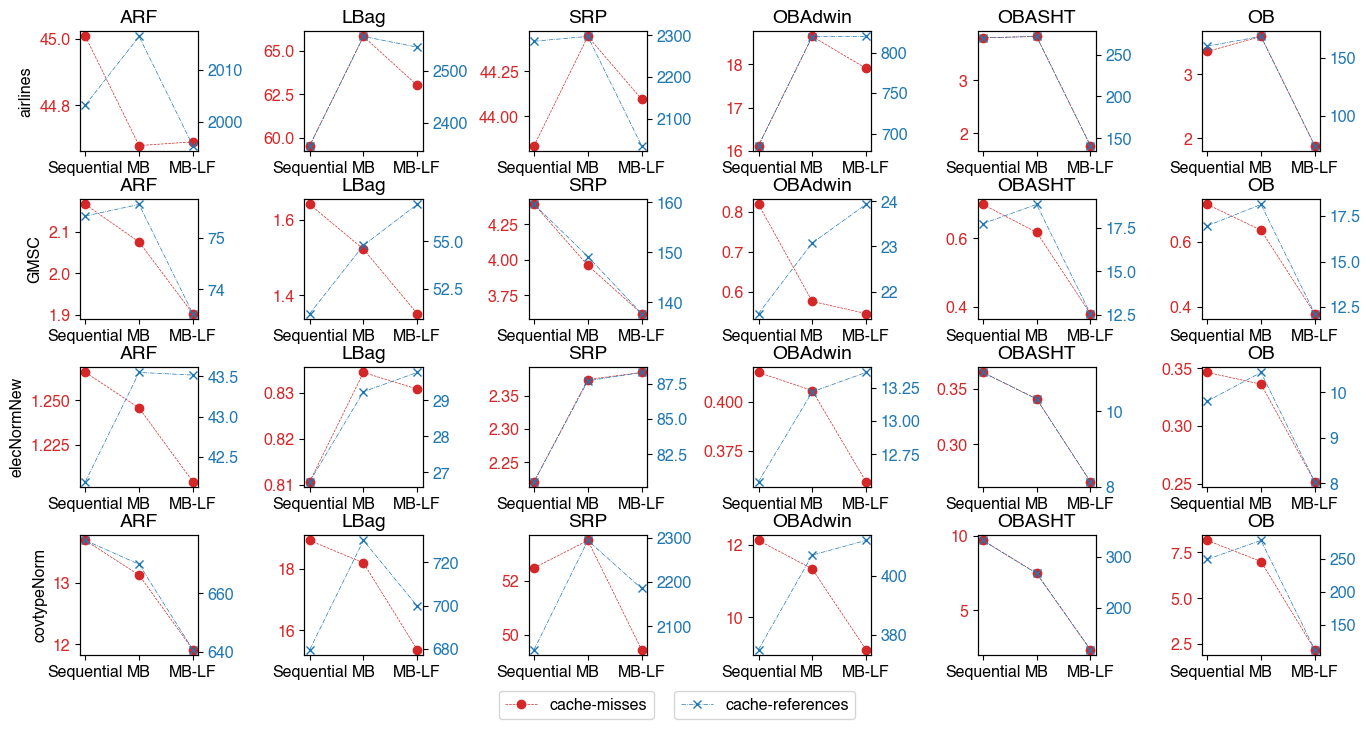

In [68]:
# output cache misses graph
linear_graph(True, False)